In [8]:
import tensorflow as tf
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from pytz import timezone
from datetime import datetime
from config import *
from utils import *
from import_data import Import_EfficientNetB7_data, Import_TripletNet_test_data
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from model.EfficientNetB7 import EfficientNetB7_model
from model.TripletNet import TripletNet_model
from tensorflow.keras.models import Model, load_model

In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
checkpoint_path = os.path.join(CHECKPOINT_PATH, os.listdir(CHECKPOINT_PATH)[-1])
if checkpoint_path:
    print(f"Checkpoint found: {checkpoint_path}")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found")

Checkpoint found: C:/Users/USER/Desktop/capstone_revised\train_result\TripletNet_cropped_data_224_1000_0.0003_4\checkpoint\checkpoint-019-0.032227-0.094645.h5


In [11]:
if MODEL_NAME == 'TripletNet':
	train_triplet_generator, test_triplet_generator = Import_TripletNet_test_data(IMAGE_SIZE, BATCH_SIZE, train_data_path=TRAIN_DATA_PATH, test_data_path=TEST_DATA_PATH).build_generators()
	model = model.get_layer('model')
	model = Model(inputs=model.input, outputs=model.output)
    
elif MODEL_NAME == 'EfficientNetB7':
	test_generator = Import_EfficientNetB7_data(IMAGE_SIZE, BATCH_SIZE, test_data_path=TEST_DATA_PATH).build_generators('test')

Found 29399 images belonging to 3 classes.
Found 6301 images belonging to 3 classes.


In [15]:
def evaluate_triplet_model(test_triplet_generator, database, model, output_path):
    y_true = []
    y_pred = []
    total_batches = len(test_triplet_generator)
    batch_count = 0

    print("Starting to evaluate batches...")
    for batch, labels in test_triplet_generator:
        if batch_count >= total_batches:
            break 
        batch_count += 1 
        print(f"Processing batch {batch_count}/{total_batches}") 
        embeddings = model.predict(batch, verbose=0) # (batch, 128)
        labels = labels.astype(int) # (batch, )
        for emb, true_label in zip(embeddings, labels):
            pred_label, _ = predict_closest_embedding(emb, database)
            y_true.append(true_label)
            y_pred.append(pred_label)
    
    print("Saving results...")
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    conf_mat = confusion_matrix(y_true, y_pred)
    df_conf_mat = pd.DataFrame(conf_mat, columns=[str(i) for i in range(conf_mat.shape[0])],
                            index=[str(i) for i in range(conf_mat.shape[1])])
    sns_heatmap = sns.heatmap(data=df_conf_mat, annot=True, fmt='d', linewidths=.5, cmap='BuGn_r')
    sns_heatmap.get_figure().savefig(f"{output_path}/confusion_matrix.png")

    target_names = [str(i) for i in range(conf_mat.shape[0])]
    report = classification_report(y_true, y_pred, digits=5, target_names=target_names)

    with open(f"{output_path}/result.txt", "w") as file:
        file.write(f"test_accuracy: {accuracy}, test_precision: {precision}, test_recall: {recall}\n")
        file.write(report)

    print(f"test_accuracy: {accuracy}, test_precision: {precision}, test_recall: {recall}")
    print(report)

Starting to process batches...
Processing batch 1/7350
Processing batch 2/7350
Processing batch 3/7350
Processing batch 4/7350
Processing batch 5/7350
Processing batch 6/7350
Processing batch 7/7350
Processing batch 8/7350
Processing batch 9/7350
Processing batch 10/7350
Processing batch 11/7350
Processing batch 12/7350
Processing batch 13/7350
Processing batch 14/7350
Processing batch 15/7350
Processing batch 16/7350
Processing batch 17/7350
Processing batch 18/7350
Processing batch 19/7350
Processing batch 20/7350
Processing batch 21/7350
Processing batch 22/7350
Processing batch 23/7350
Processing batch 24/7350
Processing batch 25/7350
Processing batch 26/7350
Processing batch 27/7350
Processing batch 28/7350
Processing batch 29/7350
Processing batch 30/7350
Processing batch 31/7350
Processing batch 32/7350
Processing batch 33/7350
Processing batch 34/7350
Processing batch 35/7350
Processing batch 36/7350
Processing batch 37/7350
Processing batch 38/7350
Processing batch 39/7350
Pro

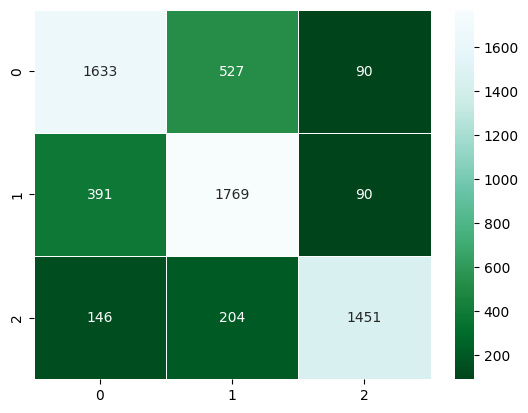

In [13]:
if not os.path.exists(TEST_RESULT_FILE_PATH):
        os.makedirs(TEST_RESULT_FILE_PATH) 

if MODEL_NAME == 'TripletNet':
    database = create_embedding_database(train_triplet_generator, model)
    evaluate_triplet_model(test_triplet_generator, database, model, TEST_RESULT_FILE_PATH)
elif MODEL_NAME == 'EfficientNetB7':
    eval = model.evaluate(test_generator)  # [test_loss, test_accuracy, test_precision, test_recall]

    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    y_true = test_generator.labels
    np.save(f"{TEST_RESULT_FILE_PATH}/y_pred.npy", y_pred)
    np.save(f"{TEST_RESULT_FILE_PATH}/y_true.npy", y_true)

    conf_mat = confusion_matrix(y_true, y_pred)
    df_conf_mat = pd.DataFrame(conf_mat, columns=[str(i) for i in range(conf_mat.shape[0])],
                               index=[str(i) for i in range(conf_mat.shape[1])])
    sns_heatmap = sns.heatmap(data=df_conf_mat, annot=True, fmt='d', linewidths=.5, cmap='BuGn_r')
    sns_heatmap.get_figure().savefig(f"{TEST_RESULT_FILE_PATH}/confusion_matrix.png")

    target_names = [str(i) for i in range(conf_mat.shape[0])]
    report = classification_report(y_true, y_pred, digits=5, target_names=target_names)

    with open(f"{TEST_RESULT_FILE_PATH}/result.txt", "w") as file:
        file.write(f"test_loss: {eval[0]}, test_accuracy: {eval[1]}, test_precision: {eval[2]}, test_recall: {eval[3]}\n")
        file.write(report)
    print(f'test_loss: {eval[0]}, test_accuracy: {eval[1]}, test_precision: {eval[2]}, test_recall: {eval[3]}')
    print(report)